In [13]:
dmdt_by_Name_Band_50x50 = '/content/drive/MyDrive/Thesis/dmdt_Analysis/Histograms/dmdt_by_Name_Band_50x50.pkl'
S_FBPCA_QSOsOnly_allbands = '/content/drive/MyDrive/Thesis/dmdt_Analysis/Histograms/FBPCA/S_FBPCA_QSOsOnly_allbands.npy'

In [14]:
### Importing common items
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-colorblind')

from sklearn.model_selection import train_test_split
from fastai.vision.all import *

In [15]:
S = np.load(S_FBPCA_QSOsOnly_allbands)
dmdt_by_Name_Band_50x50_df = pd.read_pickle(dmdt_by_Name_Band_50x50)

In [16]:
dmdt_by_Name_Band_50x50_df = dmdt_by_Name_Band_50x50_df[['type']]
dmdt_by_Name_Band_50x50_df = dmdt_by_Name_Band_50x50_df[dmdt_by_Name_Band_50x50_df['type'].isin(['Q', 'QR', 'QX'])].reset_index(drop=True)

image_list = []

for index, row in dmdt_by_Name_Band_50x50_df.iterrows():
    array = S[:, index].reshape(50, 50)
    array_normalized = (array - array.min()) / (array.max() - array.min()) * 255
    array_normalized = array_normalized.astype(np.uint8)
    image = Image.fromarray(array_normalized)
    image_list.append(image)

In [17]:
dmdt_by_Name_Band_50x50_df['image'] = image_list
del image_list

In [18]:
train_df, valid_df = train_test_split(dmdt_by_Name_Band_50x50_df, test_size=0.2, stratify=dmdt_by_Name_Band_50x50_df['type'])

In [19]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image'),
    get_y=ColReader('type'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224)
)

In [20]:
dls = data_block.dataloaders(dmdt_by_Name_Band_50x50_df, bs=512)

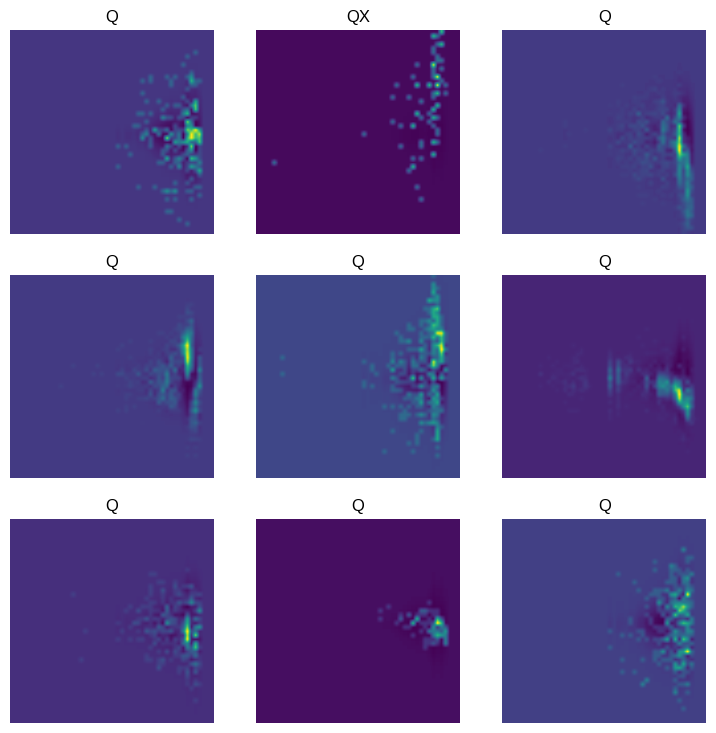

In [21]:
dls.show_batch()

In [23]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Suggested Learning Rates: Min: 0.0012022644514217973


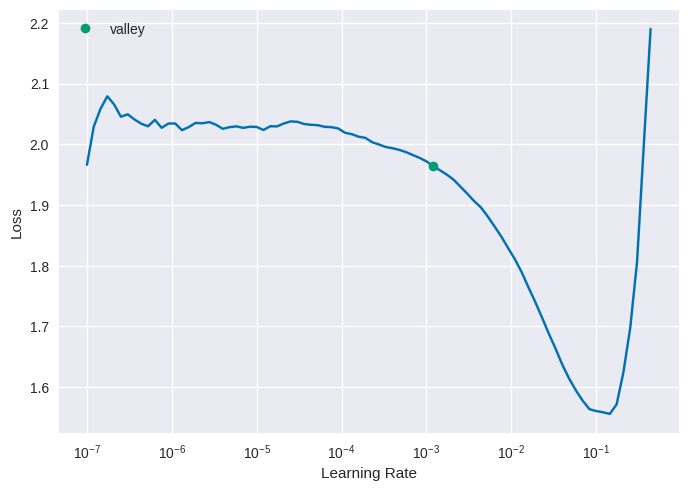

In [24]:
lr_min = learn.lr_find(show_plot=True)
print(f"Suggested Learning Rates: Min: {lr_min.valley}")

In [25]:
learn.fine_tune(5, base_lr=lr_min.valley)

epoch,train_loss,valid_loss,accuracy,time
0,1.288642,0.610018,0.820623,02:45


epoch,train_loss,valid_loss,accuracy,time
0,0.761224,0.538136,0.841819,03:10
1,0.647080,0.532247,0.843036,03:04
2,0.580717,0.528123,0.842821,03:04
3,0.546874,0.524582,0.842821,03:02
4,0.515097,0.524726,0.842965,03:02


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

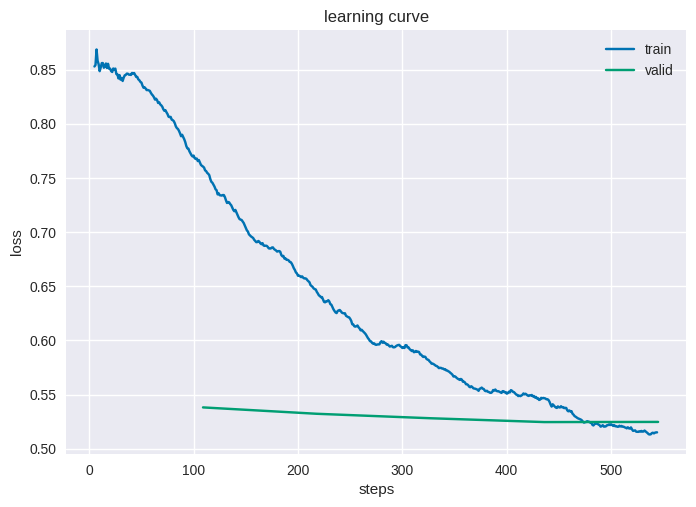

In [26]:
learn.recorder.plot_loss()

In [27]:
metrics = learn.recorder.metrics
print(metrics)

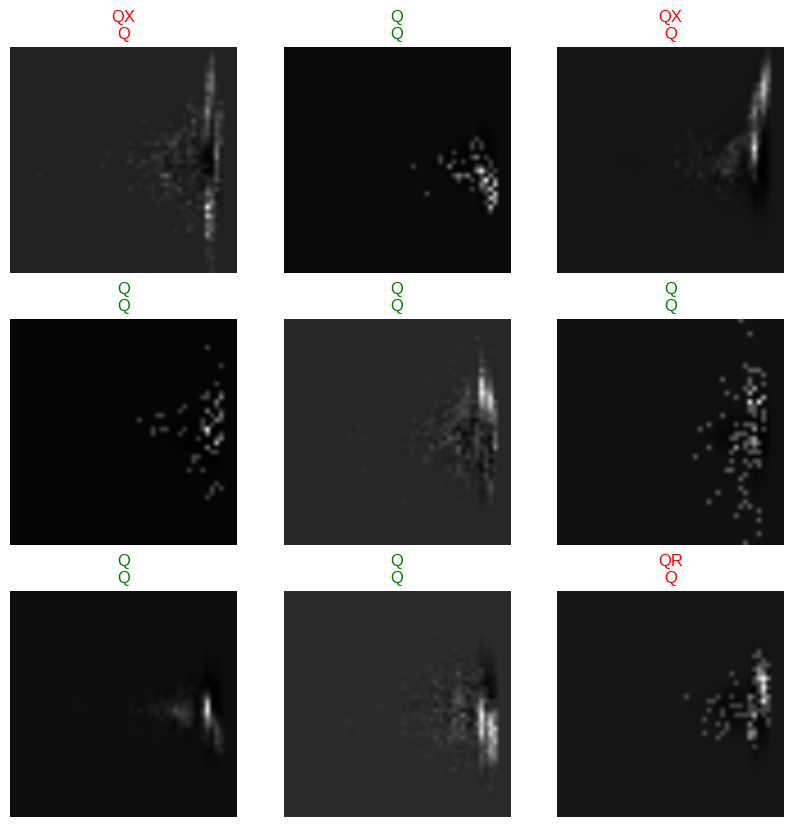

In [28]:
learn.show_results(max_n=9, figsize=(10, 10))  # Show 9 results

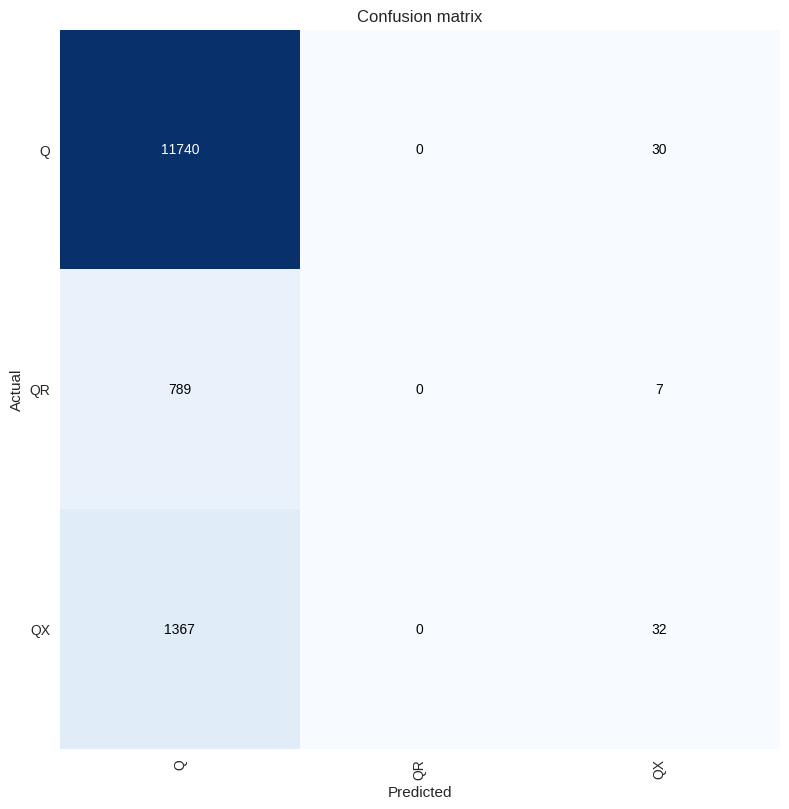

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8), dpi=100)

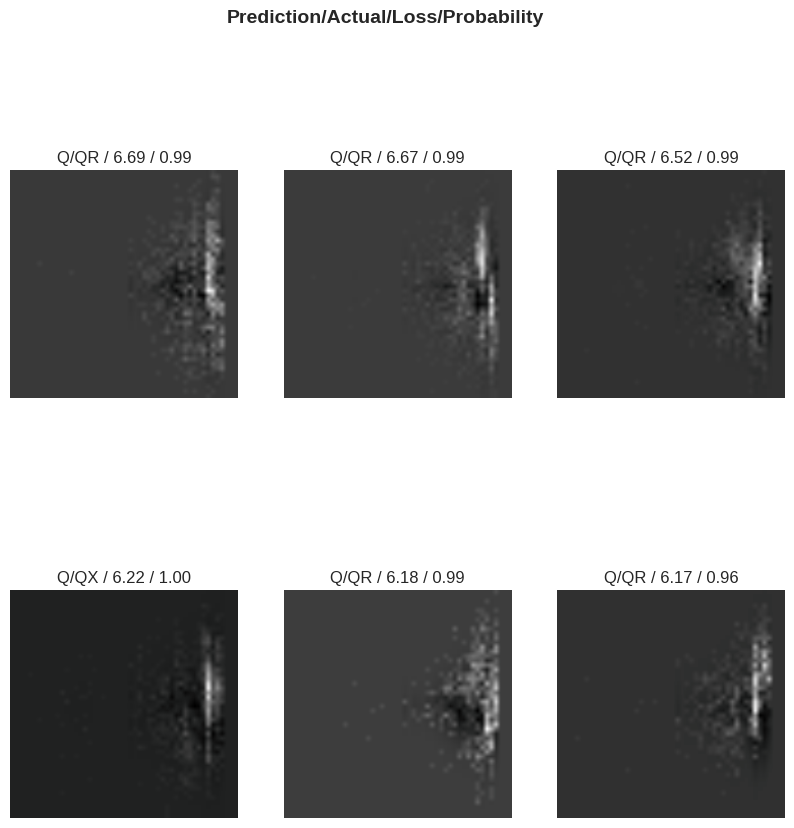

In [30]:
interp.plot_top_losses(k=6, figsize=(10, 10))  # Show 5 samples with largest loss


Now trying it with undersampling.

In [33]:
class_counts = dmdt_by_Name_Band_50x50_df['type'].value_counts()

In [34]:
from sklearn.utils import resample

# Find the minority class size
min_class_size = class_counts.min()

# Undersample each class
balanced_dfs = []
for label in class_counts.index:
    class_df = dmdt_by_Name_Band_50x50_df[dmdt_by_Name_Band_50x50_df['type'] == label]
    balanced_df = resample(class_df, replace=False, n_samples=min_class_size, random_state=42)
    balanced_dfs.append(balanced_df)

# Combine the balanced subsets
undersampled_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42)  # Shuffle

In [35]:
train_df, valid_df = train_test_split(undersampled_df, test_size=0.2, stratify=undersampled_df['type'])

In [36]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image'),
    get_y=ColReader('type'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224)
)

In [37]:
dls = data_block.dataloaders(undersampled_df, bs=512)

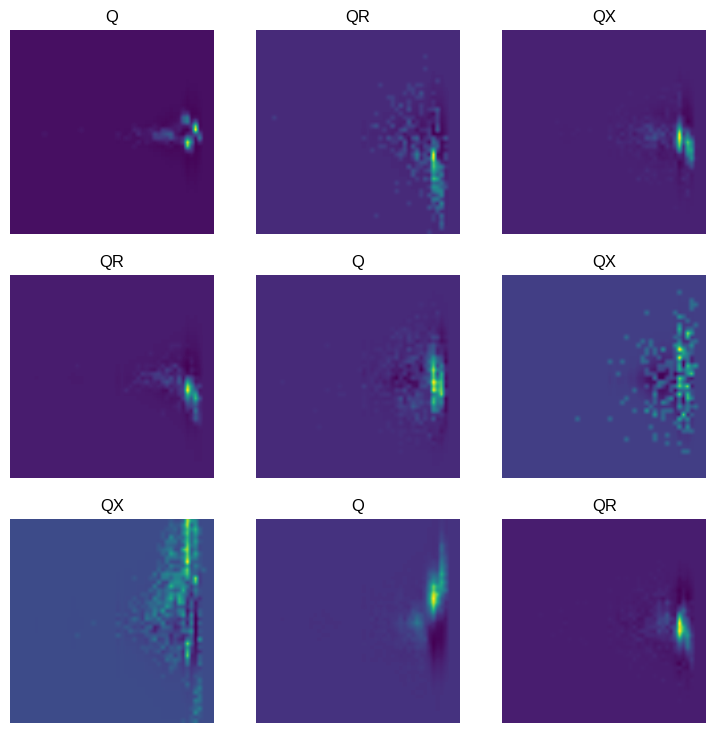

In [38]:
dls.show_batch()

In [39]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Suggested Learning Rates: Min: 0.0006918309954926372


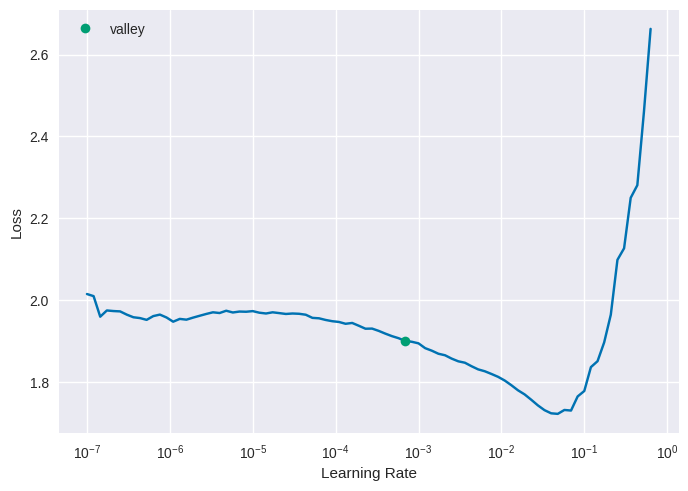

In [40]:
lr_min = learn.lr_find(show_plot=True)
print(f"Suggested Learning Rates: Min: {lr_min.valley}")

In [47]:
learn.fine_tune(20, base_lr=lr_min.valley)

epoch,train_loss,valid_loss,accuracy,time
0,1.302816,1.167620,0.416413,00:26


epoch,train_loss,valid_loss,accuracy,time
0,1.249654,1.158309,0.414242,00:31
1,1.226142,1.164612,0.426835,00:31
2,1.205582,1.163023,0.418150,00:31
3,1.178867,1.163469,0.411203,00:31
4,1.147471,1.191428,0.412505,00:31
5,1.105351,1.195064,0.435953,00:31
6,1.050970,1.210612,0.430308,00:31
7,0.987145,1.241652,0.422927,00:31
8,0.914256,1.264941,0.435519,00:31
9,0.841333,1.285806,0.425966,00:32


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

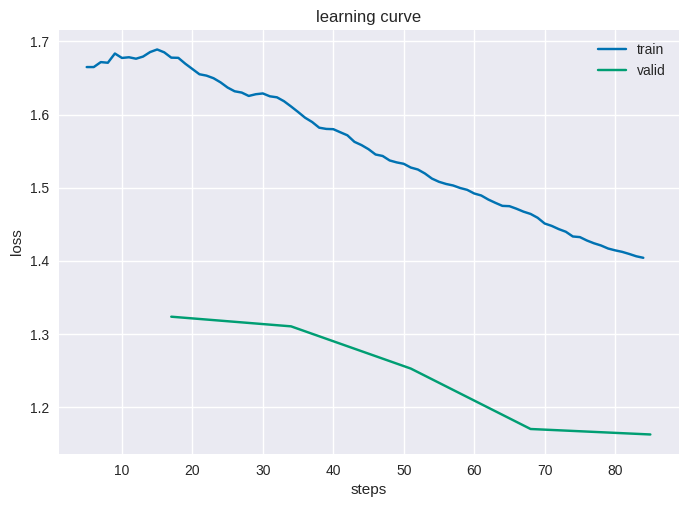

In [42]:
learn.recorder.plot_loss()

In [43]:
metrics = learn.recorder.metrics
print(metrics)

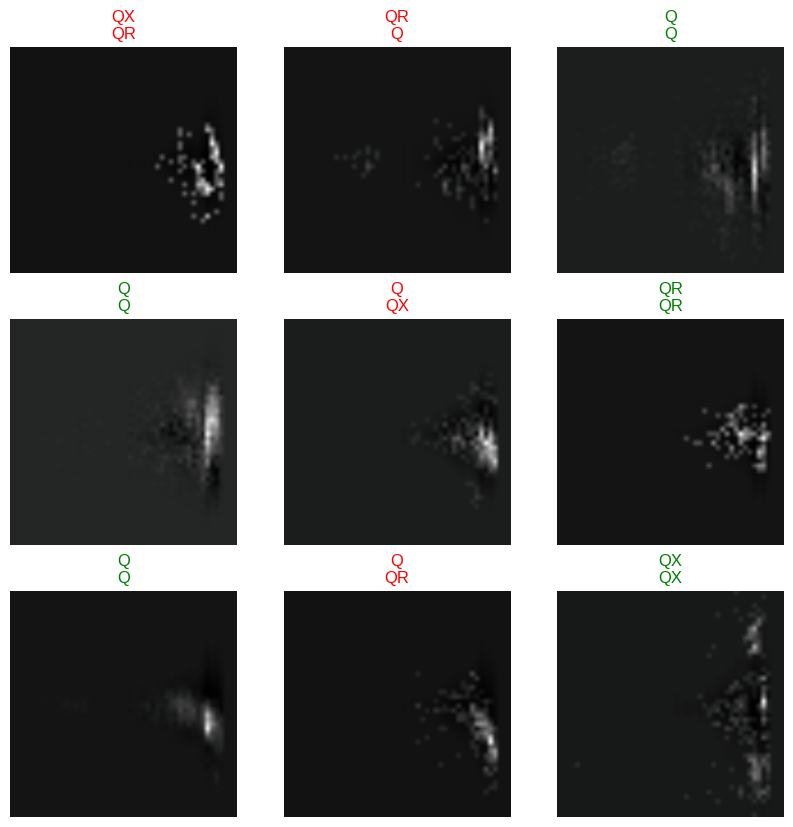

In [44]:
learn.show_results(max_n=9, figsize=(10, 10))  # Show 9 results

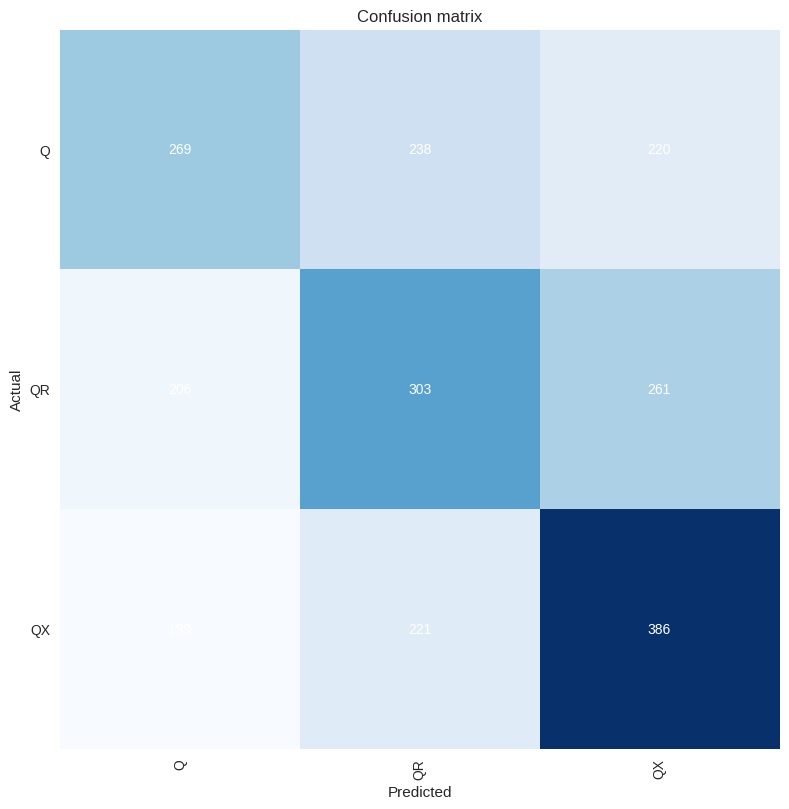

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8), dpi=100)

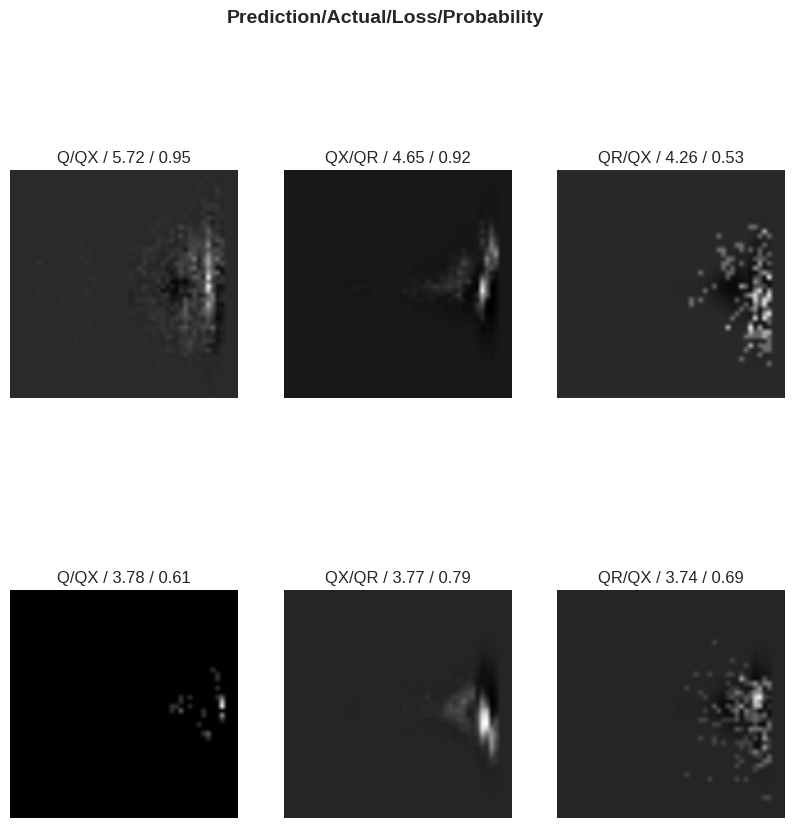

In [46]:
interp.plot_top_losses(k=6, figsize=(10, 10))  # Show 5 samples with largest loss
